If you increase the radius, the spiking neuron is able to represent the higher magnitude values. E.g. to represent a sine or cosine function, the maximum and minimum values it can take is +1 and -1, so the `radius` should be +1 and -1, i.e. the x values on which a neurons tuning curve is obtained should be between +1 and -1.

Similarly, to obtain neural representation of a constant value of 10, the radius (or `xmax` and `xmin` here) should be +10 and -10 respectively. Overall, the radius should reflect the range of the values a function can take. `intercepts` is also important, valid values are less than 1 (excluding 1). For a constant input of 10, the intercept of 0.5 seems to work best for a neuron with positive encoder of +1.

In [1]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
from nengo.utils.ensemble import response_curves, tuning_curves
SEED = 0

In [2]:
# ✍ <YOUR SOLUTION HERE>
#
def _post_synaptic_filter(t, n, tau):
    return np.exp(-(t/tau))/tau

def get_post_synaptic_filter(n, tau, T=1, dt=1e-3):
    time_seconds = np.arange(0, T, dt)
    ht = []
    for time in time_seconds:
        ht.append(_post_synaptic_filter(time, n, tau)) 
    return time_seconds, np.array(ht)*dt # Scale the signal.

In [3]:
def _get_slope(J, v, tau_RC):
    return float((J - v))/tau_RC

# Get the spike train output on x(t)
def simulate_spiking_neuron(T, dt, x, tau_RC, tau_ref, e=1, xmax=10, xmin=-10, xi=0.5, a_max=150):
    """
    Args:
        T (float): The total time of simulation.
        dt (float): Time step for each next point.
        x (numpy.ndarray): The time varying input represented value.
        tau_RC (float): The RC time constant.
        tar_ref (float): The refractory period.
        e (int): The encoding vector.
        xi (float): Intercept.
    """
    def _get_single_lif_neuron_tuning_curve():
      """
      Returns a single LIF neuron's tuning curve. The neuron is characterized by `alpha_gain` and `Jbias`.
      Note: Current translation function is `J(x) = alpha_gain * x + Jbias` to convert the stimulus x into current J.
  
      Returns:
        numpy.ndarray : A 1D array, the neural response or the firing rates (of length len(x_dist)).
      """
      x_dist = np.linspace(xmin, xmax, 101)
      LIF = lambda x: 1 / (tau_ref - tau_RC * np.log(1 - 1/x)) if x > 1 else 0
      J = alpha * x_dist * e + Jbias
      return np.array(list(map(LIF, J)))

    # Assumptions.
    v_rest, v_th = 0, 1
    time_points = np.arange(0, T, dt)
    # Size of input stimulus x should match the size of time_points and both of them should have same dt.
    assert time_points.size == x.size 
    spike_times = [] # Stores the times when the neuron spikes.
    v = []
    num_spikes = 0
    flag_threshold = False
    
    alpha = (1 / (1 - np.exp((tau_ref - 1 / a_max) / tau_RC)) - 1) / (xmax - xi)
    Jbias = (xmax - (1 / (1 - np.exp((tau_ref - 1 / a_max) / tau_RC))) * xi) / (xmax - xi)
    
    # Current Time Step `cts` where x[cts=0] = input signal x's value at time t=0, 
    #                               x[cts+1] = input signal x's value at time t=t+dt,
    #                               x[cts+2] = input signal x's value at time t=t+dt+dt, and so on.. 
    cts = 0 
    current_time = 0
    
    while(cts<int(np.round(T/dt))):
        #Get J for the current time step from the input signal.
        J = alpha*e*x[cts] + Jbias
        
        if cts==0: # First calculation of membrane potential v, therefore assuming the previous v to be v_rest.
            slope = _get_slope(J, v_rest, tau_RC)
            v_curr = v_rest + dt*slope
        else:
            slope = _get_slope(J, v[-1], tau_RC)
            v_curr = v[-1] + dt*slope
        
        if v_curr >= v_th: # If v_current >= v_th at the current_time, the neuron spikes.
            v.append(v_curr)
            num_spikes += 1
            spike_times.append(current_time)
            time_of_spike = current_time
            
            # Set the neuron's state in refractory period.
            while(current_time < time_of_spike + tau_ref):
                current_time += dt
                cts += 1
                v.append(0)
                
        elif v_curr < 0: # If the v_current goes below zero at the current time, reset it to 0
            v.append(0)
        
        else:
            v.append(v_curr)
            
        current_time += dt # update the current time at which the new membrane potential occurs.
        cts += 1
    
    assert num_spikes == len(spike_times)
    # For the last `current_time` which is greater than or equal to 1, 
    #we don't need the last calculated membrane potential, therefore v[:-1]
    #return num_spikes, spike_times, v[:-1]
    tuning_curve = _get_single_lif_neuron_tuning_curve()
    return num_spikes, spike_times, v[:], tuning_curve, np.linspace(xmin, xmax, 101)

In [4]:
# _get_spike_lines return spikes with amplitudes 1/dt
def _get_spike_lines(times, spike_times, dt=1e-3):
    spikes = []
    i = 0
    for time in times:
        if i < len(spike_times) and np.allclose(time, spike_times[i]):
            spikes.append(int(np.round(1/dt)))
            i += 1
        else:
            spikes.append(int(np.round(0/dt)))
    
    return spikes
  
def plot_spikes(T, dt, spike_times):
    times = np.arange(0, T, dt)
    spikes = _get_spike_lines(times, spike_times, dt)
    assert int(np.round(np.sum(spikes)*dt)) == len(spike_times)
    fig, ax = plt.subplots(figsize=(6,4))
    #fig.suptitle("Spike Train for constant input x = %s" % x)
    ax.plot(times, spikes)
    ax.set_xlabel("Time $t$ in seconds")
    ax.set_ylabel("Spike")

# Get the constant signal and spikes

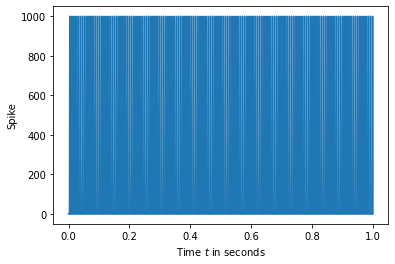

In [5]:
time_seconds, ht = get_post_synaptic_filter(n=0, tau=0.005, T=1)
const_signal = 10*np.ones(1000) # A constant signal of 10.
_, pn_spike_times, voltage, tuning_curve, xdist = simulate_spiking_neuron(1, 1e-3, const_signal, 20e-3, 2e-3, e=1)
plot_spikes(1, 1e-3, pn_spike_times)

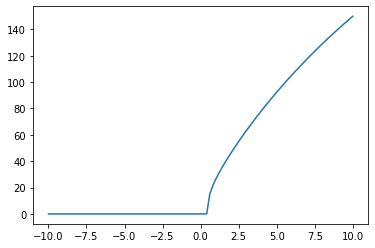

In [6]:
plt.plot(xdist, tuning_curve)

In [7]:
times = np.arange(0, 1, 1e-3)
times = np.arange(0, 1, 1e-3)
A = np.zeros((times.size, 1))
A[:, 0] = _get_spike_lines(times, pn_spike_times)
A = A.T # Change the shape of A as num_neurons x num_input_samples

In [8]:
A_filtered = np.zeros((1, times.size))

for ii in range(1): # Number of neurons n = 1.
    spikes = A[ii]
    for jj in range(0, spikes.size):
        if spikes[jj] > 0: # A spike has occurred here.
            A_filtered[ii][jj:] = A_filtered[ii][jj:] + (ht*spikes[jj])[0:1000-jj]

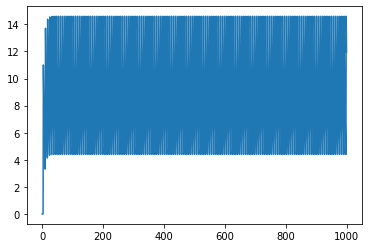

In [9]:
D = np.linalg.inv(A_filtered.dot(A_filtered.T)).dot(A_filtered).dot(const_signal.reshape(1000, 1)).T
const_signal_hat_filtered = D.dot(A_filtered)
plt.plot(const_signal_hat_filtered[0])

# Why does the smoothed value not increase continuously and rather settle?

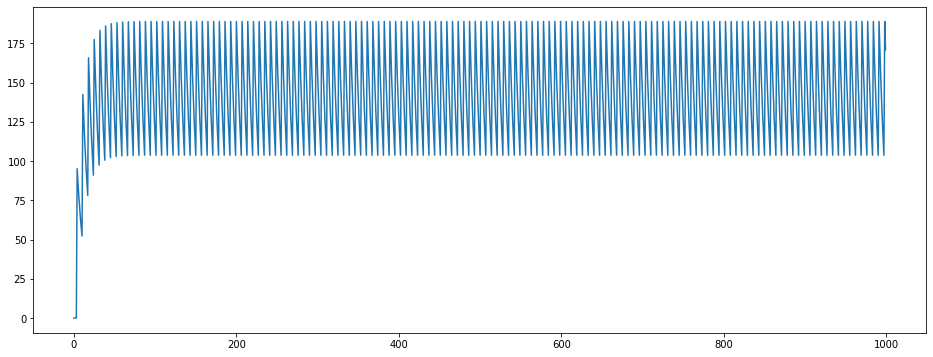

In [10]:
low_pass = nengo.Lowpass(0.010)
plt.figure(figsize=(16, 6))
plt.plot(low_pass.filt(A[0]))

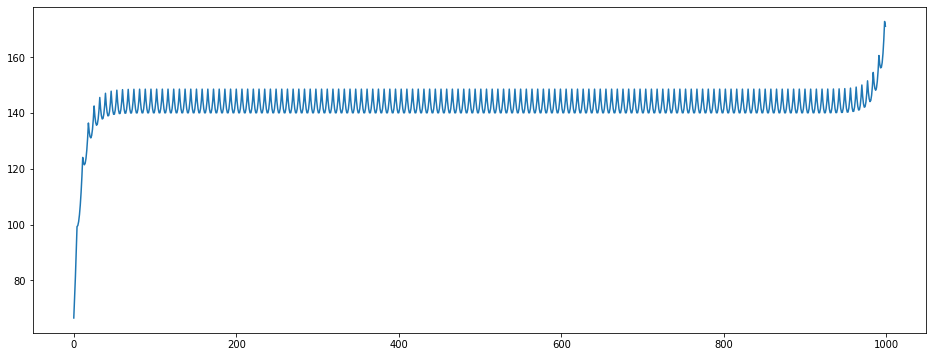

In [11]:
low_pass = nengo.Lowpass(0.010)
plt.figure(figsize=(16, 6))
plt.plot(low_pass.filtfilt(A[0]))

In [12]:
prev = 0
for i in range(1000):
  if A[0][i] != 0:
    print("%s" %(i-prev), end=", ")
    prev = i

4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

# Increased radius representation in Nengo (intercepts = 0.5 for a single neuron)

In [13]:
def plot_vals(y_lst, legend_lst):
  fig, ax = plt.subplots(figsize=(16, 6))
  for y, legend in zip(y_lst, legend_lst):
    ax.plot(y, label=legend)
  ax.set_xlabel("Time in $ms$")
  ax.set_ylabel("Filtered Value")
  ax.legend()
  ax.grid()

In [14]:
def single_neuron_filtered_value_generator(neuron_type=nengo.SpikingRectifiedLinear(), radius=1,
                                          sim_time=1, seed=SEED, const_input=10):
  """
  Simulates a single neuron. Inspects it's max_rate, intercept, and filtered values over the
  simulation period.
  """
  with nengo.Network(seed=seed) as net:
    inp_node = nengo.Node(output=const_input)
    ensemble = nengo.Ensemble(n_neurons=1, dimensions=1, radius=radius,
                              intercepts=np.array([0.05]), # nengo.dists.Uniform(0.5, 0.5),
                              neuron_type=neuron_type,seed=seed, max_rates=nengo.dists.Uniform(150, 150),
                               encoders=[[1]])
    conn = nengo.Connection(inp_node, ensemble)
    
    inp_probe = nengo.Probe(inp_node)
    otp_probe = nengo.Probe(ensemble, synapse=0.010)
    spk_probe = nengo.Probe(ensemble.neurons)
    vol_probe = nengo.Probe(ensemble.neurons, "voltage")
    
  print("Wts", conn.solver.weights)
  
  with nengo.Simulator(net) as sim:
    eval_points, activities = tuning_curves(ensemble, sim)
    sim.run(sim_time)
    
  # plot tuning curves.
  plt.plot(eval_points, activities)
  return sim, inp_probe, otp_probe, spk_probe, vol_probe

Wts False


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

"\n['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', \n'__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', \n'__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', \n'__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_initialized', '_param_init_order', '_str', 'bias', \n'copy', 'dimensions', 'encoders', 'eval_points', 'gain', 'intercepts', 'label', 'max_rates', 'n_eval_points', \n'n_neurons', 'neuron_type', 'neurons', 'noise', 'normalize_encoders', 'params', 'probeable', 'radius', 'seed', \n'size_in', 'size_out']\n"

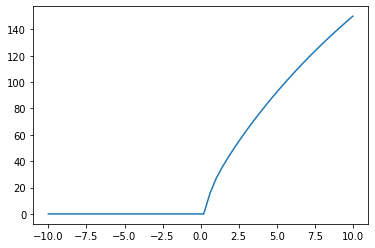

In [15]:
sim, inp_probe, otp_probe, spk_probe, vol_probe = single_neuron_filtered_value_generator(
    neuron_type=nengo.LIF(amplitude=1), 
    sim_time=1, 
    const_input=10, 
    seed=89,
    radius=10,
)
"""
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', 
'__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', 
'__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', 
'__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_initialized', '_param_init_order', '_str', 'bias', 
'copy', 'dimensions', 'encoders', 'eval_points', 'gain', 'intercepts', 'label', 'max_rates', 'n_eval_points', 
'n_neurons', 'neuron_type', 'neurons', 'noise', 'normalize_encoders', 'params', 'probeable', 'radius', 'seed', 
'size_in', 'size_out']
"""

In [16]:
np.sum(sim.data[spk_probe]/1000)

149.0

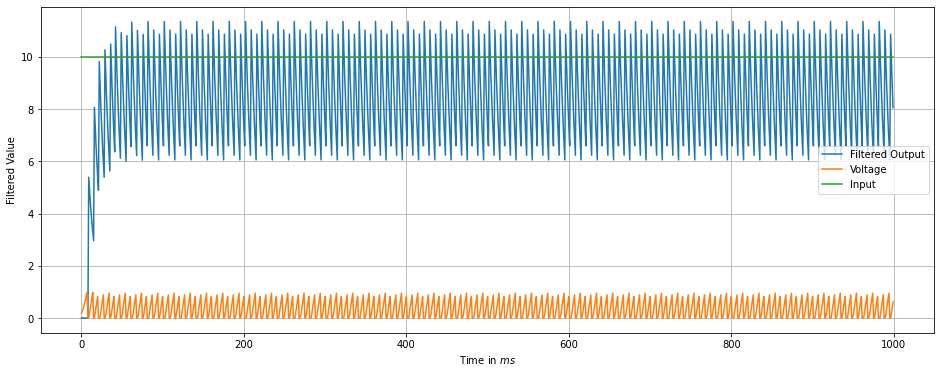

In [17]:
plot_vals(
    [
      sim.data[otp_probe], 
      sim.data[vol_probe][:, 0], 
      #sim.data[spk_probe],
      sim.data[inp_probe]
    ], 
          
    [
      "Filtered Output", 
      "Voltage", 
      #"Spikes",
      "Input",
    ])

## Potting tuning curves with increased radius

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Input scalar, x')

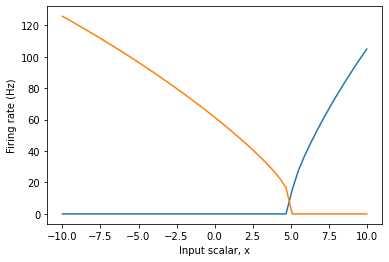

In [2]:
model = nengo.Network()
with model:
    ens_1d = nengo.Ensemble(2, dimensions=1, radius=10, intercepts=np.array([0.5, -0.5]),
                            encoders=[[1], [-1]], max_rates=nengo.dists.Uniform(100, 150))
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(ens_1d, sim)

plt.figure()
plt.plot(eval_points, activities)
# We could have alternatively shortened this to
# plt.plot(*tuning_curves(ens_1d, sim))
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input scalar, x")

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Input scalar, x')

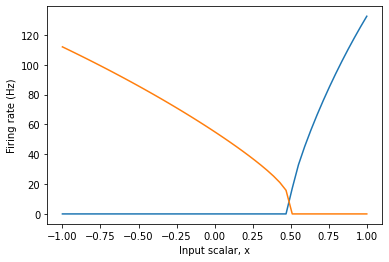

In [3]:
model = nengo.Network()
with model:
    ens_1d = nengo.Ensemble(2, dimensions=1, radius=1, intercepts=np.array([0.5, -0.5]),
                            encoders=[[1], [-1]], max_rates=nengo.dists.Uniform(100, 150))
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(ens_1d, sim)

plt.figure()
plt.plot(eval_points, activities)
# We could have alternatively shortened this to
# plt.plot(*tuning_curves(ens_1d, sim))
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input scalar, x")

In [51]:
print(sim.data[ens_1d].gain)
print(sim.data[ens_1d].bias)
print(sim.data[ens_1d].max_rates)
print(sim.data[ens_1d].intercepts)
print(sim.data[ens_1d].encoders)
#print(sim.data[ens_1d].eval_points) # For the x axis of the tuning curve.
print(sim.data[ens_1d].scaled_encoders)

[7.41780952 1.94470844]
[-2.70890476  1.97235422]
[147.61510422 126.65767039]
[ 0.5 -0.5]
[[ 1.]
 [-1.]]
[[ 0.74178095]
 [-0.19447084]]


In [38]:
print(ens_1d.gain)
print(ens_1d.max_rates)
print(ens_1d.bias)
print(ens_1d.intercepts)

None
Uniform(low=100, high=150)
None
[ 0.5 -0.5]
